In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')
from scripts.preprocessing import obtain_boxes_grouping, read_region_input_files

In [2]:
from scipy.ndimage import label, binary_fill_holes, distance_transform_edt
import numpy as np
def mask_coast_by_depth(bathy, ref_depth):
    # depth: array 240 x 240, 0 = terra, >0 = mare
    mask_land = (bathy >= ref_depth)

    # Etichetta tutte le regioni connesse di terra
    labeled, _ = label(mask_land)

    # Conta i pixel per ogni etichetta
    counts = np.bincount(labeled.ravel())

    # Ignora background (etichetta 0)
    counts[0] = 0

    labels = np.unique(labeled)[counts > 500]

    mask = np.isin(labeled, labels)

    # Crea maschera solo per la terraferma vera
    return binary_fill_holes(mask)

def find_leftmost_pixel(mask):

    leftmost_index = []
    for i in range(mask.shape[0]):
        if np.any(mask[i, :]):
            for j in range(mask.shape[1]):
                if mask[i, j]:
                    leftmost_index.append(j)
                    break
        else:
            leftmost_index.append(np.nan)

    return np.array(leftmost_index)

In [3]:
from scipy.ndimage import label, binary_erosion

def extract_coastline(bathy, ref_depth=0, min_pixels=500):
    # 1. Maschera terra: profondità >= ref_depth (es. 0)
    land_mask = bathy >= ref_depth

    # 2. Etichettatura connessa
    labeled, _ = label(land_mask)
    counts = np.bincount(labeled.ravel())
    counts[0] = 0  # ignora background

    # 3. Seleziona la massa di terra più grande o abbastanza grande
    keep_labels = np.where(counts > min_pixels)[0]
    mask = np.isin(labeled, keep_labels)
    mask = binary_fill_holes(mask)
    # 4. Estrai bordo con erosione
    edge = mask & ~binary_erosion(mask)

    return edge

In [4]:
atlantic = read_region_input_files('../configs/atlantic_regions.input')
pacific = read_region_input_files('../configs/pacific_regions.input')

atlantic_groups = obtain_boxes_grouping(atlantic)
pacific_groups = obtain_boxes_grouping(pacific)

In [5]:
depths = [250, 500, 1000, 1500, 2000]

In [7]:
bathy = xr.open_dataarray('../../data/processed/bathymetry.nc')

In [8]:
boxes = [box for region in pacific.keys() for box in pacific[region] ]
bins = np.linspace(0, 100, 20)

dist_by_depth = pd.DataFrame(index=range(1, 1 + len(boxes)), columns=depths)

for i, box in enumerate(boxes):
    lon_min, lon_max, lat_min, lat_max = box[0], box[1], box[2], box[3]
    b = bathy.sel(longitude = slice(box[0], box[1]), latitude = slice(box[2], box[3]))

    for depth in depths:
        distances_by_region = []

        coastline_mask = extract_coastline(b, ref_depth=0)
        isobath_mask   = extract_coastline(b, ref_depth=-depth)  # o -1000, dipende da cosa cerchi

        # Mappa distanza da costa
        dist_map = distance_transform_edt(~coastline_mask)

        # Distanza della isobata dalla costa
        distances = dist_map[isobath_mask] * 4  # km
        distances = distances[distances > 0]# rimuovi valori zero

        dist_by_depth.loc[i+1, depth] = np.median(distances).astype(int)


dist_by_depth

,250,500,1000,1500,2000
1,140,167,172,192,209
2,17,24,41,52,62
3,24,25,37,80,96
4,25,36,44,44,80
5,8,11,16,25,32
6,50,56,62,67,88
7,17,20,28,48,103
8,38,50,53,56,114
9,14,20,32,49,59
10,5,8,16,20,24


,250,500,1000,1500,2000
California Current System,"[24, 14, 58]","[25, 16, 64]","[37, 23, 76]","[80, 44, 132]","[96, 50, 163]"
Central America,"[17, 8, 33]","[20, 11, 34]","[28, 16, 46]","[48, 24, 85]","[103, 48, 242]"
Humboldt Current System,"[43, 28, 61]","[52, 32, 69]","[60, 35, 78]","[66, 42, 84]","[84, 56, 96]"


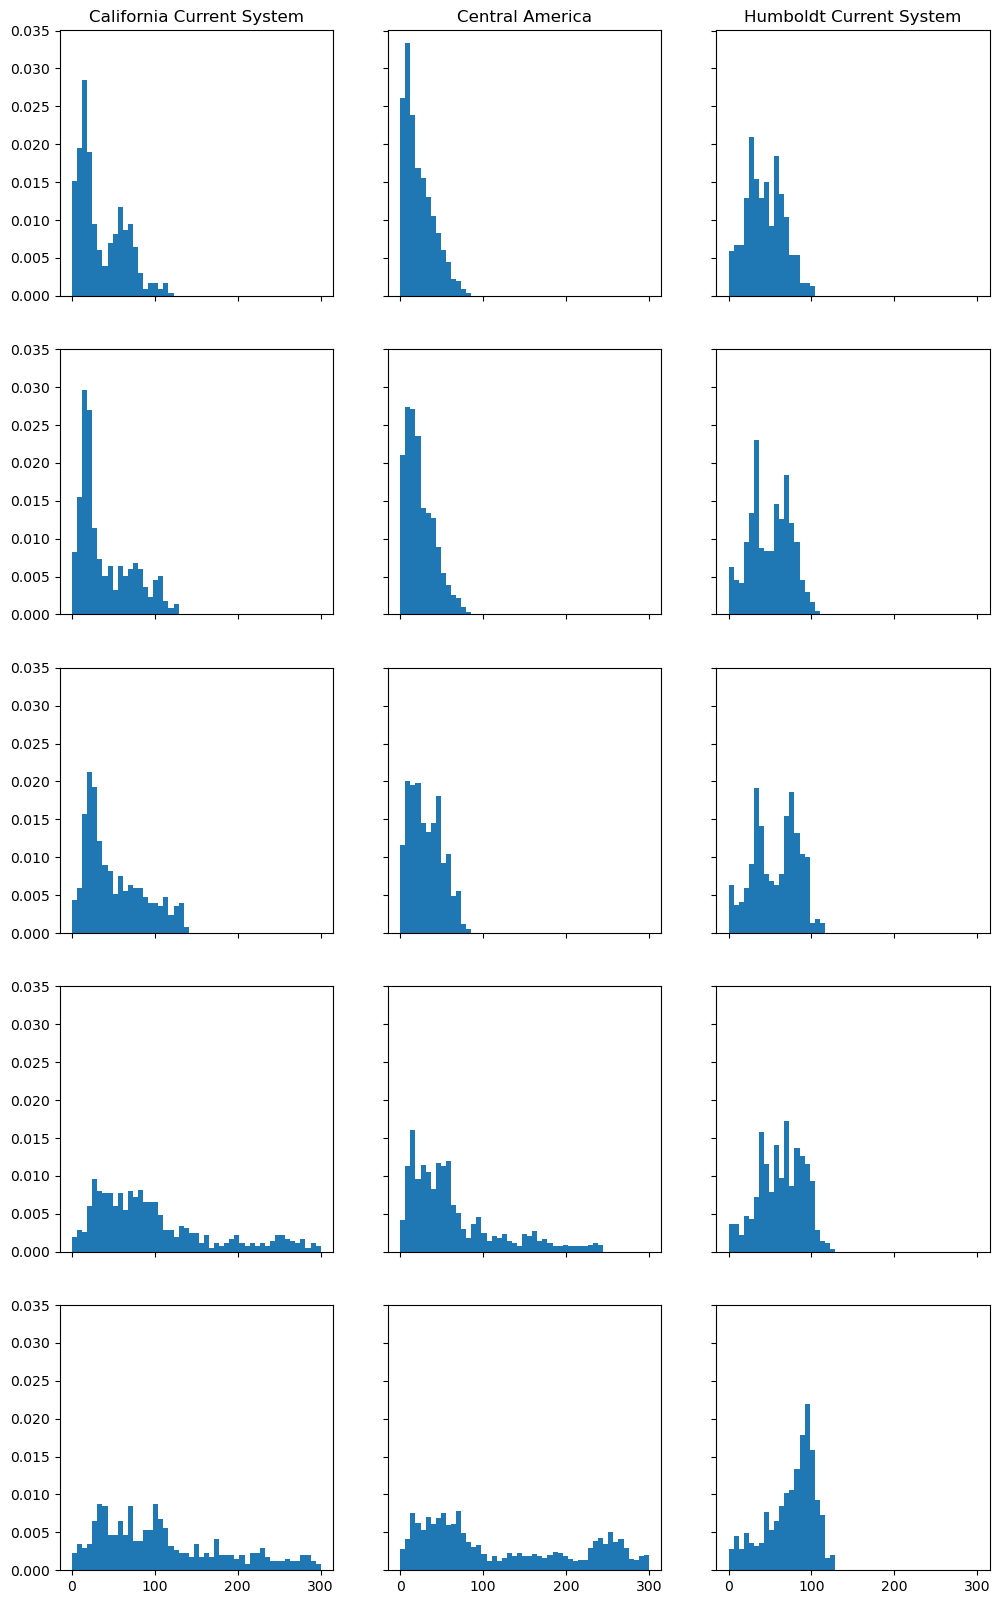

In [9]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (12, 20), sharex=True, sharey = True)
bins = np.linspace(0, 300, 50)

dist_by_depth = pd.DataFrame(index=pacific.keys(), columns=depths)

for i, (region, boxes) in enumerate(zip(pacific.keys(), pacific.values())):

    for j, depth in enumerate(depths):
        distances_by_region = []
        for box in boxes:
            lon_min, lon_max, lat_min, lat_max = box[0], box[1], box[2], box[3]
            b = bathy.sel(longitude = slice(box[0], box[1]), latitude = slice(box[2], box[3]))

            coastline_mask = extract_coastline(b, ref_depth=0)
            isobath_mask   = extract_coastline(b, ref_depth=-depth)  # o -1000, dipende da cosa cerchi

            # Mappa distanza da costa
            dist_map = distance_transform_edt(~coastline_mask)

            # Distanza della isobata dalla costa
            distances = dist_map[isobath_mask] * 4  # km
            distances = distances[distances > 0] # rimuovi valori zero

        axs[j, i].hist(distances, density = True, bins = bins)
        if j == 0:
            axs[j, i].set_title(region)
        distances_by_region.append(distances)

        distances_by_region = np.concatenate(distances_by_region)

        dist_by_depth.loc[region, depth] = [np.median(distances_by_region).astype(int), np.quantile(distances_by_region, 0.25).astype(int), np.quantile(distances_by_region, 0.75).astype(int)]


dist_by_depth

,250,500,1000,1500,2000
Canary Current System,"[85, 45, 128]","[88, 42, 134]","[97, 50, 158]","[96, 52, 160]","[103, 57, 161]"
Central Africa,"[46, 40, 56]","[51, 45, 64]","[62, 55, 77]","[80, 69, 96]","[111, 88, 140]"
Benguela Current System,"[84, 59, 105]","[120, 100, 136]","[140, 120, 156]","[160, 139, 176]","[179, 157, 196]"


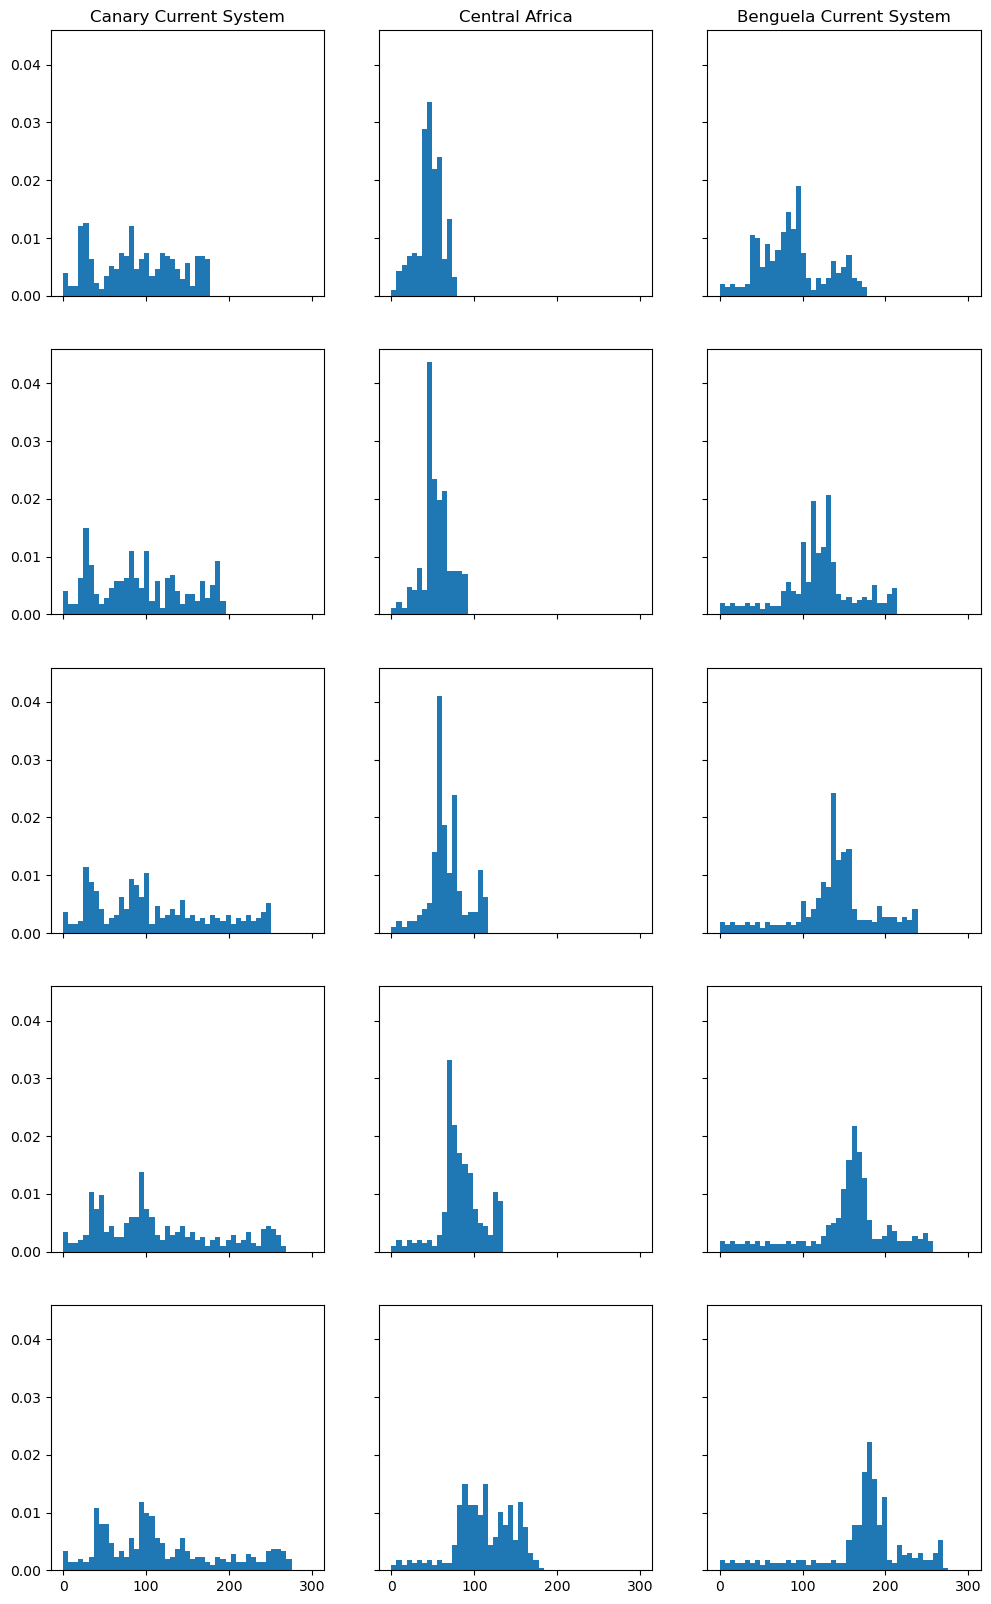

In [10]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (12, 20), sharex=True, sharey = True)
bins = np.linspace(0, 300, 50)

dist_by_depth = pd.DataFrame(index=atlantic.keys(), columns=depths)

for i, (region, boxes) in enumerate(zip(atlantic.keys(), atlantic.values())):

    for j, depth in enumerate(depths):
        distances_by_region = []
        for box in boxes:
            lon_min, lon_max, lat_min, lat_max = box[0], box[1], box[2], box[3]
            b = bathy.sel(longitude = slice(box[0], box[1]), latitude = slice(box[2], box[3]))

            coastline_mask = extract_coastline(b, ref_depth=0)
            isobath_mask   = extract_coastline(b, ref_depth=-depth)  # o -1000, dipende da cosa cerchi

            # Mappa distanza da costa
            dist_map = distance_transform_edt(~coastline_mask)

            # Distanza della isobata dalla costa
            distances = dist_map[isobath_mask] * 4  # km
            distances = distances[distances > 0] # rimuovi valori zero

        axs[j, i].hist(distances, density = True, bins = bins)
        if j == 0:
            axs[j, i].set_title(region)
        distances_by_region.append(distances)

        distances_by_region = np.concatenate(distances_by_region)

        dist_by_depth.loc[region, depth] = [np.median(distances_by_region).astype(int), np.quantile(distances_by_region, 0.25).astype(int), np.quantile(distances_by_region, 0.75).astype(int)]


dist_by_depth